# **ADA project**

* [Part I. Data Pre-Treatment](#PartI)    
    * [1) Pre-processing Data](#I.1)
        * [1.1) Import Data](#I.1.1)
        * [1.2) Are quotations unique?](#I.1.2)
        * [1.3) Punctuation Removal](#I.1.3)
        * [1.4) Lowering the text](#I.1.4)
        * [1.5) Tokenization](#I.1.5)
        * [1.6) Stop word removal](#I.1.6)
        * [1.7) Lemmatization](#I.1.7)
        * [1.8) Do we have only phase E quotations?](#I.1.8)
    * [2) Pre-analyzing Data](#2)
        * [2.1) Comparison before and after pre-processing](#I.2.1)
            * [2.1.1) Analysis about characters](#I.2.1.1)
            * [2.1.2) Analysis about words](#I.2.1.2)
        * [2.2) Selection of words AND comparison before and after selection](#I.2.2)
        * [2.3) Selection of quotations AND comparison before and after selection](#I.2.3)
            * [2.3.1) Dropping quotations where the main speaker is "None"](#I.2.3.1)
            * [2.3.2) Dropping quotations with too weak speaker probability](#I.2.3.2)
            * [2.3.3) Dropping quotations which do not have a sufficient number of words](#I.2.3.3)
        * [2.4) Final adjustments](#I.2.4)
* [Part II. Our project about Trump](#PartII) 
    * [0) Data and functions](#II.0)
        * [0.1) Data](#II.0.1)
        * [0.2) LDA function](#II.0.2)
    * [1) Question 1](#II.1)

In [1]:
import bz2
import json
import pandas as pd
import string
import re
import nltk
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt

# Part I. Data Pre-Treatment <a class="anchor" id="PartI"></a>

## 1) Pre-processing Data  <a class="anchor" id="I.1"></a>

### 1.1) Import Data  <a class="anchor" id="I.1.1"></a>

To avoid having to download and import all the data in this Jupyter Notebook, we opened all the data on Google Colab from Google Drive (cf. Mounting Google Drive) and we retrieved only the data that interested us for our project. We end up with two files: a file where Trump is the speaker and a file where the word "trump" appears in the quotation. The code used on Google Colab is the following:
```
import bz2
import json

input_files = [f'/content/drive/MyDrive/Quotebank/quotes-20{i}.json.bz2' for i in range(15, 21)]
file_about_trump = '/content/quotes-about-trump.json.bz2'
file_from_trump = '/content/quotes-from-trump.json.bz2'

for input_file in input_files:
  with bz2.open(input_file, 'rb') as s_file:
        about_file = bz2.open(file_about_trump, 'wb')
        from_file = bz2.open(file_from_trump, 'wb')
        for instance in s_file:
        instance = json.loads(instance) # loading a sample
                trump_speaking = instance['speaker'].lower().__contains__('trump')
                about_trump = instance['quotation'].lower().__contains__('trump')
                if trump_speaking:
                from_file.write((json.dumps(instance)+'\n').encode('utf-8'))
                elif about_trump:
                        about_file.write((json.dumps(instance)+'\n').encode('utf-8'))
        about_file.close()
        from_file.close()
```

We open the fisrst file where Trump is the speaker:

In [2]:
data = []
with bz2.open('data/quotes-from-trump.json.bz2', "rt") as data_file :
    for line in data_file :
        try :
            lignedata = json.loads(line)
            data.append(lignedata)
        except:
            continue

df_from = pd.DataFrame()

df_from["quoteID"] = list(map(lambda d : d["quoteID"], data))
df_from["quotation"] = list(map(lambda d : d["quotation"], data))
df_from["speaker"] = list(map(lambda d : d["speaker"], data))
df_from["qids"] = list(map(lambda d : d["qids"], data))
df_from["date"] = list(map(lambda d : d["date"], data))
df_from["numOccurrences"] = list(map(lambda d : d["numOccurrences"], data))
df_from["probas"] = list(map(lambda d : d["probas"], data))
df_from["urls"] = list(map(lambda d : d["urls"], data))
df_from["phase"] = list(map(lambda d : d["phase"], data))

df_from.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2020-02-19-010736,But I happen to like Prime Minister (Narendra)...,Donald Trump,"[Q22686, Q27947481]",2020-02-19 03:24:32,8,"[[Donald Trump, 0.4138], [President Donald Tru...",[https://www.orissapost.com/donald-trump-hints...,E
1,2020-02-07-012379,but [ President ] Trump (was) eager to make a ...,President Donald Trump,[Q22686],2020-02-07 23:05:05,1,"[[President Donald Trump, 0.5698], [None, 0.43...",[http://uspolitics.einnews.com/article/5092030...,E
2,2020-02-22-004519,But think of it: A man leaks classified inform...,President Donald Trump,[Q22686],2020-02-22 16:58:48,4,"[[President Donald Trump, 0.6539], [None, 0.21...",[http://rss.cnn.com/~r/rss/cnn_allpolitics/~3/...,E
3,2020-01-15-024779,"Here we go again, another con job by the do no...",President Donald Trump,[Q22686],2020-01-15 00:00:00,66,"[[President Donald Trump, 0.7226], [None, 0.13...",[http://feeds.foxnews.com/~r/foxnews/politics/...,E
4,2020-01-25-013605,How we ever got involved in South Korea in the...,President Donald Trump,[Q22686],2020-01-25 00:00:00,35,"[[President Donald Trump, 0.7131], [None, 0.21...",[http://www.kob.com/news/in-recording-trump-as...,E


Then we open the file where the word "trump" appears in the quotations:

In [3]:
data = []
with bz2.open('data/quotes-about-trump.json.bz2', "rt") as data_file :
    for line in data_file :
        try :
            lignedata = json.loads(line)
            data.append(lignedata)
        except:
            continue

df_about = pd.DataFrame()

df_about["quoteID"] = list(map(lambda d : d["quoteID"], data))
df_about["quotation"] = list(map(lambda d : d["quotation"], data))
df_about["speaker"] = list(map(lambda d : d["speaker"], data))
df_about["qids"] = list(map(lambda d : d["qids"], data))
df_about["date"] = list(map(lambda d : d["date"], data))
df_about["numOccurrences"] = list(map(lambda d : d["numOccurrences"], data))
df_about["probas"] = list(map(lambda d : d["probas"], data))
df_about["urls"] = list(map(lambda d : d["urls"], data))
df_about["phase"] = list(map(lambda d : d["phase"], data))

df_about.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2020-02-28-003530,"Among all voters, all six Democratic candidate...",None,[],2020-02-28 02:33:55,1,"[[None, 0.7969], [Donald Trump, 0.2031]]",[https://www.politicususa.com/2020/02/27/disas...,E
1,2020-04-10-003311,And you would have the governor stay on messag...,None,[],2020-04-10 18:53:18,1,"[[None, 0.7468], [Ron DeSantis, 0.2003], [Dona...",[https://insurancenewsnet.com/oarticle/coronav...,E
2,2020-01-28-006585,Anyone with direct knowledge of what happened ...,John Bolton,"[Q24676423, Q3079582, Q311269, Q53578866, Q622...",2020-01-28 11:00:12,1,"[[John Bolton, 0.4195], [None, 0.3545], [Presi...",[https://blogforiowa.com/2020/01/28/today-at-n...,E
3,2020-01-22-008784,"At one point, the Perpetual Guardian four-day ...",Andrew Barnes,[Q57009500],2020-01-22 16:03:41,3,"[[Andrew Barnes, 0.8488], [None, 0.1512]]",[https://www.stuff.co.nz/business/118957804/th...,E
4,2020-01-02-006280,Because basically the logic of everything that...,Ben Rhodes,"[Q4886343, Q4886346, Q4886347, Q4886348]",2020-01-02 00:00:00,1,"[[Ben Rhodes, 0.8202], [None, 0.16], [Nicolle ...",[https://www.rawstory.com/2020/01/nicolle-wall...,E


Finally we combine the two dataframes in a single one:

In [4]:
#Concatenate the two DataFrame in a single one for pre-processing
df = pd.concat([df_about, df_from], axis=0)

df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2020-02-28-003530,"Among all voters, all six Democratic candidate...",None,[],2020-02-28 02:33:55,1,"[[None, 0.7969], [Donald Trump, 0.2031]]",[https://www.politicususa.com/2020/02/27/disas...,E
1,2020-04-10-003311,And you would have the governor stay on messag...,None,[],2020-04-10 18:53:18,1,"[[None, 0.7468], [Ron DeSantis, 0.2003], [Dona...",[https://insurancenewsnet.com/oarticle/coronav...,E
2,2020-01-28-006585,Anyone with direct knowledge of what happened ...,John Bolton,"[Q24676423, Q3079582, Q311269, Q53578866, Q622...",2020-01-28 11:00:12,1,"[[John Bolton, 0.4195], [None, 0.3545], [Presi...",[https://blogforiowa.com/2020/01/28/today-at-n...,E
3,2020-01-22-008784,"At one point, the Perpetual Guardian four-day ...",Andrew Barnes,[Q57009500],2020-01-22 16:03:41,3,"[[Andrew Barnes, 0.8488], [None, 0.1512]]",[https://www.stuff.co.nz/business/118957804/th...,E
4,2020-01-02-006280,Because basically the logic of everything that...,Ben Rhodes,"[Q4886343, Q4886346, Q4886347, Q4886348]",2020-01-02 00:00:00,1,"[[Ben Rhodes, 0.8202], [None, 0.16], [Nicolle ...",[https://www.rawstory.com/2020/01/nicolle-wall...,E


### 1.2) Are quotations unique?  <a class="anchor" id="I.1.2"></a>

In [5]:
print(f"Are quotations unique? {df.quotation.is_unique}")

Are quotations unique? True


### 1.3) Punctuation Removal  <a class="anchor" id="I.1.3"></a>

In [6]:
# Defining the function to remove punctuation
def remove_punctuation(text):
    punctuationfree = "".join([i for i in text if i not in string.punctuation])
    return punctuationfree

# Storing the puntuation free text
df['quote_punctfree']= df['quotation'].apply(lambda x: remove_punctuation(x))

df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,quote_punctfree
0,2020-02-28-003530,"Among all voters, all six Democratic candidate...",None,[],2020-02-28 02:33:55,1,"[[None, 0.7969], [Donald Trump, 0.2031]]",[https://www.politicususa.com/2020/02/27/disas...,E,Among all voters all six Democratic candidates...
1,2020-04-10-003311,And you would have the governor stay on messag...,None,[],2020-04-10 18:53:18,1,"[[None, 0.7468], [Ron DeSantis, 0.2003], [Dona...",[https://insurancenewsnet.com/oarticle/coronav...,E,And you would have the governor stay on messag...
2,2020-01-28-006585,Anyone with direct knowledge of what happened ...,John Bolton,"[Q24676423, Q3079582, Q311269, Q53578866, Q622...",2020-01-28 11:00:12,1,"[[John Bolton, 0.4195], [None, 0.3545], [Presi...",[https://blogforiowa.com/2020/01/28/today-at-n...,E,Anyone with direct knowledge of what happened ...
3,2020-01-22-008784,"At one point, the Perpetual Guardian four-day ...",Andrew Barnes,[Q57009500],2020-01-22 16:03:41,3,"[[Andrew Barnes, 0.8488], [None, 0.1512]]",[https://www.stuff.co.nz/business/118957804/th...,E,At one point the Perpetual Guardian fourday we...
4,2020-01-02-006280,Because basically the logic of everything that...,Ben Rhodes,"[Q4886343, Q4886346, Q4886347, Q4886348]",2020-01-02 00:00:00,1,"[[Ben Rhodes, 0.8202], [None, 0.16], [Nicolle ...",[https://www.rawstory.com/2020/01/nicolle-wall...,E,Because basically the logic of everything that...


### 1.4) Lowering the text  <a class="anchor" id="I.1.4"></a>

In [7]:
df['quote_punctfree_low'] = df['quote_punctfree'].apply(lambda x: x.lower())

df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,quote_punctfree,quote_punctfree_low
0,2020-02-28-003530,"Among all voters, all six Democratic candidate...",None,[],2020-02-28 02:33:55,1,"[[None, 0.7969], [Donald Trump, 0.2031]]",[https://www.politicususa.com/2020/02/27/disas...,E,Among all voters all six Democratic candidates...,among all voters all six democratic candidates...
1,2020-04-10-003311,And you would have the governor stay on messag...,None,[],2020-04-10 18:53:18,1,"[[None, 0.7468], [Ron DeSantis, 0.2003], [Dona...",[https://insurancenewsnet.com/oarticle/coronav...,E,And you would have the governor stay on messag...,and you would have the governor stay on messag...
2,2020-01-28-006585,Anyone with direct knowledge of what happened ...,John Bolton,"[Q24676423, Q3079582, Q311269, Q53578866, Q622...",2020-01-28 11:00:12,1,"[[John Bolton, 0.4195], [None, 0.3545], [Presi...",[https://blogforiowa.com/2020/01/28/today-at-n...,E,Anyone with direct knowledge of what happened ...,anyone with direct knowledge of what happened ...
3,2020-01-22-008784,"At one point, the Perpetual Guardian four-day ...",Andrew Barnes,[Q57009500],2020-01-22 16:03:41,3,"[[Andrew Barnes, 0.8488], [None, 0.1512]]",[https://www.stuff.co.nz/business/118957804/th...,E,At one point the Perpetual Guardian fourday we...,at one point the perpetual guardian fourday we...
4,2020-01-02-006280,Because basically the logic of everything that...,Ben Rhodes,"[Q4886343, Q4886346, Q4886347, Q4886348]",2020-01-02 00:00:00,1,"[[Ben Rhodes, 0.8202], [None, 0.16], [Nicolle ...",[https://www.rawstory.com/2020/01/nicolle-wall...,E,Because basically the logic of everything that...,because basically the logic of everything that...


### 1.5) Tokenization  <a class="anchor" id="I.1.5"></a>

In [ ]:
# Defining function for tokenization
def tokenization(text):
    tokens = re.split('\W+',text)
    return tokens

# Applying function to the column
df['quote_punctfree_low_token']= df['quote_punctfree_low'].apply(lambda x: tokenization(x))

df.head()

### 1.6) Stop word removal  <a class="anchor" id="I.1.6"></a>

In [ ]:
# Stop words present in the library
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

# Defining the function to remove stopwords from tokenized text
def remove_stopwords(text):
    output = [i for i in text if i not in stopwords]
    return output

# Applying the function
df['quote_punctfree_low_token_NoStopWord'] = df['quote_punctfree_low_token'].apply(lambda x: remove_stopwords(x))

df.head()

### 1.7) Lemmatization  <a class="anchor" id="I.1.7"></a>

In [ ]:
# Defining the object for Lemmatization
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()

# Defining the function for lemmatization
def lemmatizer(text):
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text

# Applying the function
df['quote_punctfree_low_token_NoStopWord_lemm'] = df['quote_punctfree_low_token_NoStopWord'].apply(lambda x: lemmatizer(x))
df['final_quote'] = df['quote_punctfree_low_token_NoStopWord_lemm']

df.head()

### 1.8) Do we have only phase E quotations?  <a class="anchor" id="1.8"></a>

In [ ]:
df.groupby(df.phase).agg('count')

## 2) Pre-analyzing Data  <a class="anchor" id="I.2"></a>

### 2.1) Comparison before and after pre-processing  <a class="anchor" id="I.2.1"></a>

#### 2.1.1) Analysis about characters  <a class="anchor" id="I.2.1.1"></a>

In [ ]:
# Creation of a new table for the analysis
analyze = df.loc[:, ['quoteID', 'quotation', 'final_quote']].copy(deep=True)

In [ ]:
# Creation of a new column with the number of characters per citation (spaces included)
analyze["ch_quote"] = analyze["quotation"].apply(lambda x: len(x))

analyze.head()

In [ ]:
# Creation of a new column with the number of characters of the final quote without tokenization
analyze["ch_final_quote"] = (df["final_quote"].apply(lambda x: ' '.join(x))).apply(lambda x: len(x))

analyze.head()

In [ ]:
# Creation of a new column with the percentage of characters removed after pre-processing
analyze["ch_removed"] = (analyze["ch_quote"]-analyze["ch_final_quote"])*100/analyze["ch_quote"]

analyze.head()

In [ ]:
# Plot the distribution of the number of characters by quotation before pre-processing data and after pre-processing data
# And plot of the distribution of the percentage of characters removed after pre-processing

fig, ax = plt.subplots(1,2,figsize=(14,4))

ax[0].hist(analyze.ch_removed, bins=100, histtype='step')
ax[0].set_title('Percentage of characters removed after pre-processing')
ax[0].set_xlabel('Percentage of characters removed')
ax[0].set_ylabel('Number of quotations')

ax[1].hist([analyze.ch_quote, analyze.ch_final_quote], bins=100, histtype='step', label=['before pre-processing', 'after pre-processing'])
ax[1].set_title('Number of characters')
ax[1].set_xlabel('Number of characters by quotation')
ax[1].set_ylabel('Number of quotations')

plt.legend()
plt.show()

In [ ]:
# Describe the column about the percentage of characters removed
analyze.ch_removed.describe()

The percentage of characters removed after pre-processing seems to follow a Gaussian law centered on 35 percents. This is confirmed by the description of the column, as the median is 35%. It means that we removed around one third of the quotation characters. The standard deviation is quite low (11%), meaning that the percentage of characters removed is quite similar accross all the column.

The distribution of the character number per citation seems to follow an heavy-tailed distribution. This could be useful to confirm that for the rest of the analysis, so let's use a logarithmic scale.

In [ ]:
# Same but with log scale for the x-axis
plt.figure(figsize=(5,4))
array0 = plt.hist(analyze.ch_quote, bins=100, log=True, histtype='step')
array1 = plt.hist(analyze.ch_final_quote, bins=100, log=True, histtype='step')
plt.xlabel('Number of characters by quotation')
plt.ylabel('Number of quotations (in log scale)')
plt.title('Number of characters')
plt.legend(['before pre-processing', 'after pre-processing'])
plt.show()

In [ ]:
# Same but with log scale for the x-axis and the y-axis
plt.figure(figsize=(5,4))
plt.loglog(array0[1][1:],array0[0])
plt.loglog(array1[1][1:],array1[0])
plt.xlabel('Number of characters by quotation (in log scale)')
plt.ylabel('Number of quotations (in log scale)')
plt.title('Number of characters')
plt.legend(['before pre-processing', 'after pre-processing'])
plt.show()

The log-log axis confirms that distributions follow power laws.

In [ ]:
# Same but with log scale for the y-axis and cumulative
plt.figure(figsize=(5,4))
array_cumulative0 = plt.hist(analyze.ch_quote, bins=100, log=True, histtype='step', cumulative=-1)
array_cumulative1 = plt.hist(analyze.ch_final_quote, bins=100, log=True, histtype='step', cumulative=-1)
plt.xlabel('Number of characters by quotation')
plt.ylabel('Number of quotations (in log scale)')
plt.title('Number of characters')
plt.legend(['before pre-processing', 'after pre-processing'])
plt.show()

In [ ]:
# Same but with log scale for the x-axis and the y-axis and cumulative
plt.figure(figsize=(5,4))
plt.loglog(array_cumulative0[1][1:],array_cumulative0[0])
plt.loglog(array_cumulative1[1][1:],array_cumulative1[0])
plt.xlabel('Number of characters by quotation (in log scale)')
plt.ylabel('Number of quotations (in log scale)')
plt.title('Number of characters')
plt.legend(['before pre-processing', 'after pre-processing'])
plt.show()

The shift between the two curves confirms that we successfully removed characters between data before processing and data after processing.

#### 2.1.2) Analysis about words  <a class="anchor" id="I.2.1.2"></a>

In [ ]:
# Creation of a two columns with the number of words per citation before and after NoStopWord (cf. pre-processing)
analyze["wd_quote"] = df["quote_punctfree_low_token"].apply(lambda x: len(x))
analyze["wd_final_quote"] = df["final_quote"].apply(lambda x: len(x))

analyze.head()

In [23]:
# Creation of a new column with the percentage of words removed after pre-processing
analyze["wd_removed"] = (analyze["wd_quote"]-analyze["wd_final_quote"])*100/analyze["wd_quote"]

analyze.head()

,quoteID,quotation,final_quote,ch_quote,ch_final_quote,ch_removed,wd_quote,wd_final_quote,wd_removed
0,2020-02-28-003530,"Among all voters, all six Democratic candidate...","[among, voter, six, democratic, candidate, tes...",383,261,31.853786,63,40,36.507937
1,2020-04-10-003311,And you would have the governor stay on messag...,"[would, governor, stay, message, political, en...",128,84,34.375000,23,12,47.826087
2,2020-01-28-006585,Anyone with direct knowledge of what happened ...,"[anyone, direct, knowledge, happened, testify,...",286,200,30.069930,45,27,40.000000
3,2020-01-22-008784,"At one point, the Perpetual Guardian four-day ...","[one, point, perpetual, guardian, fourday, wee...",126,88,30.158730,21,13,38.095238
4,2020-01-02-006280,Because basically the logic of everything that...,"[basically, logic, everything, trump, actually...",257,152,40.856031,44,21,52.272727


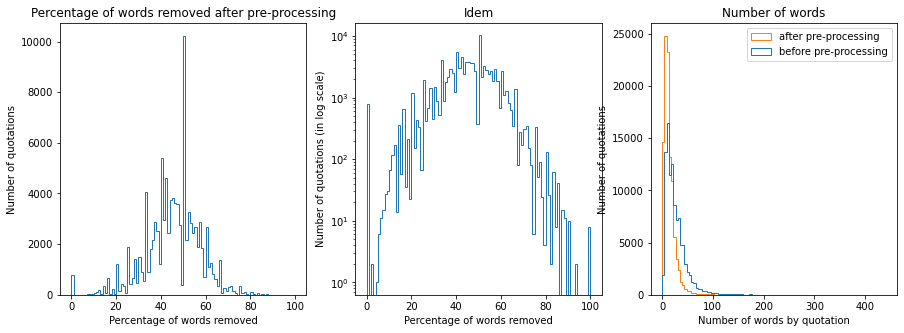

In [24]:
# Plot the distribution of the number of words by quotation before pre-processing data and after pre-processing data
# And plot of the distribution of the percentage of words removed after pre-processing

fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[0].hist(analyze.wd_removed, bins=100, histtype='step')
ax[0].set_title('Percentage of words removed after pre-processing')
ax[0].set_xlabel('Percentage of words removed')
ax[0].set_ylabel('Number of quotations')

ax[1].hist(analyze.wd_removed, bins=100, log=True, histtype='step')
ax[1].set_title('Idem')
ax[1].set_xlabel('Percentage of words removed')
ax[1].set_ylabel('Number of quotations (in log scale)')

ax[2].hist([analyze.wd_quote, analyze.wd_final_quote], bins=100, histtype='step', label=['before pre-processing', 'after pre-processing'])
ax[2].set_title('Number of words')
ax[2].set_xlabel('Number of words by quotation')
ax[2].set_ylabel('Number of quotations')

plt.legend()
plt.show()

In [25]:
#Describe the column about the percentage of characters removed
analyze.wd_removed.describe()

count    102700.000000
mean         45.305967
std          12.104298
min           0.000000
25%          38.461538
50%          46.153846
75%          52.941176
max         100.000000
Name: wd_removed, dtype: float64

Again, it seems that the number of words per quotations follow a heavy-tailed distribution, so we will check it later.
The words removed follow a Gaussion distribution centered on around 45%, which is confirmed by the median (46 % of the quotation words removed). The std (12%) shows that the dispersion is quite low.

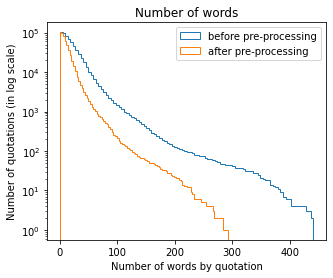

In [26]:
# Same but with log scale for the y-axis and cumulative
plt.figure(figsize=(5,4))
array_cumulative0 = plt.hist(analyze.wd_quote, bins=100, log=True, histtype='step', cumulative=-1)
array_cumulative1 = plt.hist(analyze.wd_final_quote, bins=100, log=True, histtype='step', cumulative=-1)
plt.xlabel('Number of words by quotation')
plt.ylabel('Number of quotations (in log scale)')
plt.title('Number of words')
plt.legend(['before pre-processing', 'after pre-processing'])
plt.show()

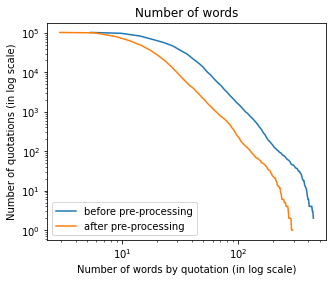

In [27]:
# Same but with log scale for the x-axis and the y-axis and cumulative
plt.figure(figsize=(5,4))
plt.loglog(array_cumulative0[1][1:],array_cumulative0[0])
plt.loglog(array_cumulative1[1][1:],array_cumulative1[0])
plt.xlabel('Number of words by quotation (in log scale)')
plt.ylabel('Number of quotations (in log scale)')
plt.title('Number of words')
plt.legend(['before pre-processing', 'after pre-processing'])
plt.show()

Once again, the shift between the two curves confirm that words were removed during the pre-processing.

### 2.2) Selection of words AND comparison before and after selection  <a class="anchor" id="I.2.2"></a>

In [28]:
analyze[analyze['wd_final_quote']<10]['final_quote'].head(20)

5     [best, week, u, president, trump, politically,...
6                       [personal, level, agree, trump]
8     [would, know, conversation, donald, trump, pre...
11    [seems, like, big, thing, trump, got, elected,...
12                    [god, tom, fired, trump, got, go]
17    [gap, communication, ability, grasp, demand, m...
29                       [dont, want, say, beat, trump]
34    [make, mistake, campaign, send, donald, trump,...
36    [playing, trumpet, christchurch, symphony, orc...
38           [onethird, programming, supportive, trump]
39    [pull, like, trump, duck, like, donald, presid...
49    [doubt, realdonaldtrump, recorded, corrupt, po...
51            [missing, lesson, donald, trump, victory]
53             [president, trump, massachusetts, happy]
58            [selling, access, president, like, trump]
66                    [trump, wasnt, paying, attention]
67    [proud, trump, leadership, fighting, coronavirus]
68                            [say, dump, say, t

In [29]:
# Create a column with the number of characters per word
analyze["ch_per_wd"] = analyze["final_quote"].apply(lambda x: [len(x[i]) for i in range (0, len(x))])
analyze.head()

,quoteID,quotation,final_quote,ch_quote,ch_final_quote,ch_removed,wd_quote,wd_final_quote,wd_removed,ch_per_wd
0,2020-02-28-003530,"Among all voters, all six Democratic candidate...","[among, voter, six, democratic, candidate, tes...",383,261,31.853786,63,40,36.507937,"[5, 5, 3, 10, 9, 6, 3, 9, 5, 6, 5, 5, 5, 9, 1,..."
1,2020-04-10-003311,And you would have the governor stay on messag...,"[would, governor, stay, message, political, en...",128,84,34.375000,23,12,47.826087,"[5, 8, 4, 7, 9, 3, 5, 10, 3, 8, 6, 5]"
2,2020-01-28-006585,Anyone with direct knowledge of what happened ...,"[anyone, direct, knowledge, happened, testify,...",286,200,30.069930,45,27,40.000000,"[6, 6, 9, 8, 7, 5, 14, 4, 4, 8, 8, 6, 7, 5, 8,..."
3,2020-01-22-008784,"At one point, the Perpetual Guardian four-day ...","[one, point, perpetual, guardian, fourday, wee...",126,88,30.158730,21,13,38.095238,"[3, 5, 9, 8, 7, 4, 8, 5, 3, 4, 4, 10, 6]"
4,2020-01-02-006280,Because basically the logic of everything that...,"[basically, logic, everything, trump, actually...",257,152,40.856031,44,21,52.272727,"[9, 5, 10, 5, 8, 4, 13, 4, 2, 7, 3, 8, 2, 6, 7..."


In [30]:
# Median of number of character per words
list_ch_per_word = []
for ligne in analyze["ch_per_wd"] :
    list_ch_per_word += ligne

pd.Series(list_ch_per_word).median()    

6.0

In [31]:
# Dropping words with less than 3 characters (3 included)

def drop_words(quote) :
    new_quote = []
    for word in quote :
        if len(word) > 3 :
            new_quote.append(word)
    return new_quote
   
df["final_quote_SelectWd"] = df["final_quote"].apply(drop_words) 

df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,quote_punctfree,quote_punctfree_low,quote_punctfree_low_token,quote_punctfree_low_token_NoStopWord,quote_punctfree_low_token_NoStopWord_lemm,final_quote,final_quote_SelectWd
0,2020-02-28-003530,"Among all voters, all six Democratic candidate...",None,[],2020-02-28 02:33:55,1,"[[None, 0.7969], [Donald Trump, 0.2031]]",[https://www.politicususa.com/2020/02/27/disas...,E,Among all voters all six Democratic candidates...,among all voters all six democratic candidates...,"[among, all, voters, all, six, democratic, can...","[among, voters, six, democratic, candidates, t...","[among, voter, six, democratic, candidate, tes...","[among, voter, six, democratic, candidate, tes...","[among, voter, democratic, candidate, tested, ..."
1,2020-04-10-003311,And you would have the governor stay on messag...,None,[],2020-04-10 18:53:18,1,"[[None, 0.7468], [Ron DeSantis, 0.2003], [Dona...",[https://insurancenewsnet.com/oarticle/coronav...,E,And you would have the governor stay on messag...,and you would have the governor stay on messag...,"[and, you, would, have, the, governor, stay, o...","[would, governor, stay, message, political, en...","[would, governor, stay, message, political, en...","[would, governor, stay, message, political, en...","[would, governor, stay, message, political, up..."
2,2020-01-28-006585,Anyone with direct knowledge of what happened ...,John Bolton,"[Q24676423, Q3079582, Q311269, Q53578866, Q622...",2020-01-28 11:00:12,1,"[[John Bolton, 0.4195], [None, 0.3545], [Presi...",[https://blogforiowa.com/2020/01/28/today-at-n...,E,Anyone with direct knowledge of what happened ...,anyone with direct knowledge of what happened ...,"[anyone, with, direct, knowledge, of, what, ha...","[anyone, direct, knowledge, happened, testify,...","[anyone, direct, knowledge, happened, testify,...","[anyone, direct, knowledge, happened, testify,...","[anyone, direct, knowledge, happened, testify,..."
3,2020-01-22-008784,"At one point, the Perpetual Guardian four-day ...",Andrew Barnes,[Q57009500],2020-01-22 16:03:41,3,"[[Andrew Barnes, 0.8488], [None, 0.1512]]",[https://www.stuff.co.nz/business/118957804/th...,E,At one point the Perpetual Guardian fourday we...,at one point the perpetual guardian fourday we...,"[at, one, point, the, perpetual, guardian, fou...","[one, point, perpetual, guardian, fourday, wee...","[one, point, perpetual, guardian, fourday, wee...","[one, point, perpetual, guardian, fourday, wee...","[point, perpetual, guardian, fourday, week, mo..."
4,2020-01-02-006280,Because basically the logic of everything that...,Ben Rhodes,"[Q4886343, Q4886346, Q4886347, Q4886348]",2020-01-02 00:00:00,1,"[[Ben Rhodes, 0.8202], [None, 0.16], [Nicolle ...",[https://www.rawstory.com/2020/01/nicolle-wall...,E,Because basically the logic of everything that...,because basically the logic of everything that...,"[because, basically, the, logic, of, everythin...","[basically, logic, everything, trump, actually...","[basically, logic, everything, trump, actually...","[basically, logic, everything, trump, actually...","[basically, logic, everything, trump, actually..."


In [32]:
# Add quotations words selected to analyze dataframe :
analyze["final_quote_SelectWd"] = df["final_quote_SelectWd"]

# Create a column with the number of characters per selected word
analyze["ch_per_SelectWd"] = analyze["final_quote_SelectWd"].apply(lambda x: [len(x[i]) for i in range (0, len(x))])
analyze.head() 

,quoteID,quotation,final_quote,ch_quote,ch_final_quote,ch_removed,wd_quote,wd_final_quote,wd_removed,ch_per_wd,final_quote_SelectWd,ch_per_SelectWd
0,2020-02-28-003530,"Among all voters, all six Democratic candidate...","[among, voter, six, democratic, candidate, tes...",383,261,31.853786,63,40,36.507937,"[5, 5, 3, 10, 9, 6, 3, 9, 5, 6, 5, 5, 5, 9, 1,...","[among, voter, democratic, candidate, tested, ...","[5, 5, 10, 9, 6, 9, 5, 6, 5, 5, 5, 9, 5, 6, 4,..."
1,2020-04-10-003311,And you would have the governor stay on messag...,"[would, governor, stay, message, political, en...",128,84,34.375000,23,12,47.826087,"[5, 8, 4, 7, 9, 3, 5, 10, 3, 8, 6, 5]","[would, governor, stay, message, political, up...","[5, 8, 4, 7, 9, 5, 10, 8, 6, 5]"
2,2020-01-28-006585,Anyone with direct knowledge of what happened ...,"[anyone, direct, knowledge, happened, testify,...",286,200,30.069930,45,27,40.000000,"[6, 6, 9, 8, 7, 5, 14, 4, 4, 8, 8, 6, 7, 5, 8,...","[anyone, direct, knowledge, happened, testify,...","[6, 6, 9, 8, 7, 5, 14, 4, 4, 8, 8, 6, 7, 5, 8,..."
3,2020-01-22-008784,"At one point, the Perpetual Guardian four-day ...","[one, point, perpetual, guardian, fourday, wee...",126,88,30.158730,21,13,38.095238,"[3, 5, 9, 8, 7, 4, 8, 5, 3, 4, 4, 10, 6]","[point, perpetual, guardian, fourday, week, mo...","[5, 9, 8, 7, 4, 8, 5, 4, 4, 10, 6]"
4,2020-01-02-006280,Because basically the logic of everything that...,"[basically, logic, everything, trump, actually...",257,152,40.856031,44,21,52.272727,"[9, 5, 10, 5, 8, 4, 13, 4, 2, 7, 3, 8, 2, 6, 7...","[basically, logic, everything, trump, actually...","[9, 5, 10, 5, 8, 4, 13, 4, 7, 8, 6, 7, 4, 9, 4..."


In [33]:
# Median of number of character per selected words
list_ch_per_word = []
for ligne in analyze["ch_per_SelectWd"] :
    list_ch_per_word += ligne

pd.Series(list_ch_per_word).median()

6.0

### 2.3) Selection of quotations AND comparison before and after selection  <a class="anchor" id="I.2.3"></a>

In [34]:
# Creation of a new dataframe where we will select only interesting quotations
df_select = df.copy(deep=True)
df_select = df.drop(['quote_punctfree', 'quote_punctfree_low', 'quote_punctfree_low_token', 'quote_punctfree_low_token_NoStopWord', 'quote_punctfree_low_token_NoStopWord_lemm', 'final_quote'], 1)
df_select.head()

/tmp/ipykernel_9505/1247061734.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_select = df.drop(['quote_punctfree', 'quote_punctfree_low', 'quote_punctfree_low_token', 'quote_punctfree_low_token_NoStopWord', 'quote_punctfree_low_token_NoStopWord_lemm', 'final_quote'], 1)


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,final_quote_SelectWd
0,2020-02-28-003530,"Among all voters, all six Democratic candidate...",None,[],2020-02-28 02:33:55,1,"[[None, 0.7969], [Donald Trump, 0.2031]]",[https://www.politicususa.com/2020/02/27/disas...,E,"[among, voter, democratic, candidate, tested, ..."
1,2020-04-10-003311,And you would have the governor stay on messag...,None,[],2020-04-10 18:53:18,1,"[[None, 0.7468], [Ron DeSantis, 0.2003], [Dona...",[https://insurancenewsnet.com/oarticle/coronav...,E,"[would, governor, stay, message, political, up..."
2,2020-01-28-006585,Anyone with direct knowledge of what happened ...,John Bolton,"[Q24676423, Q3079582, Q311269, Q53578866, Q622...",2020-01-28 11:00:12,1,"[[John Bolton, 0.4195], [None, 0.3545], [Presi...",[https://blogforiowa.com/2020/01/28/today-at-n...,E,"[anyone, direct, knowledge, happened, testify,..."
3,2020-01-22-008784,"At one point, the Perpetual Guardian four-day ...",Andrew Barnes,[Q57009500],2020-01-22 16:03:41,3,"[[Andrew Barnes, 0.8488], [None, 0.1512]]",[https://www.stuff.co.nz/business/118957804/th...,E,"[point, perpetual, guardian, fourday, week, mo..."
4,2020-01-02-006280,Because basically the logic of everything that...,Ben Rhodes,"[Q4886343, Q4886346, Q4886347, Q4886348]",2020-01-02 00:00:00,1,"[[Ben Rhodes, 0.8202], [None, 0.16], [Nicolle ...",[https://www.rawstory.com/2020/01/nicolle-wall...,E,"[basically, logic, everything, trump, actually..."


In [35]:
# Number of quotations before doing the selection
NbIni_quotes = len(df_select)
NbIni_quotes

102700

In [36]:
# Checking that there is no NA for quotations and speakers
print("{} of NA quotations".format(df_select[df_select.quotation.isnull()].shape[0]))
print("{} of NA speakers".format(df_select[df_select.speaker.isnull()].shape[0]))

0 of NA quotations
0 of NA speakers


#### 2.3.1) Dropping quotations where the main speaker is "None"  <a class="anchor" id="I.2.3.1"></a>

In [37]:
# Dropping rows where the main speaker is "None"
indexNames = df_select[df_select['speaker']=='None'].index
df_select.drop(indexNames, inplace=True)
df_select.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,final_quote_SelectWd
2,2020-01-28-006585,Anyone with direct knowledge of what happened ...,John Bolton,"[Q24676423, Q3079582, Q311269, Q53578866, Q622...",2020-01-28 11:00:12,1,"[[John Bolton, 0.4195], [None, 0.3545], [Presi...",[https://blogforiowa.com/2020/01/28/today-at-n...,E,"[anyone, direct, knowledge, happened, testify,..."
3,2020-01-22-008784,"At one point, the Perpetual Guardian four-day ...",Andrew Barnes,[Q57009500],2020-01-22 16:03:41,3,"[[Andrew Barnes, 0.8488], [None, 0.1512]]",[https://www.stuff.co.nz/business/118957804/th...,E,"[point, perpetual, guardian, fourday, week, mo..."
4,2020-01-02-006280,Because basically the logic of everything that...,Ben Rhodes,"[Q4886343, Q4886346, Q4886347, Q4886348]",2020-01-02 00:00:00,1,"[[Ben Rhodes, 0.8202], [None, 0.16], [Nicolle ...",[https://www.rawstory.com/2020/01/nicolle-wall...,E,"[basically, logic, everything, trump, actually..."
5,2020-02-05-010601,"best week [ US President ] Trump has had, poli...",Greg Sheridan,[Q5606248],2020-02-05 08:31:35,1,"[[Greg Sheridan, 0.8975], [None, 0.1025]]",[http://www.skynews.com.au/details/_6129694652...,E,"[best, week, president, trump, politically, si..."
6,2020-02-12-012865,"But on a personal level, I agree with Trump,",Ilham Aliyev,[Q57371],2020-02-12 10:05:14,1,"[[Ilham Aliyev, 0.8786], [None, 0.0915], [Pres...",[https://www.timesofisrael.com/azerbaijan-memo...,E,"[personal, level, agree, trump]"


In [38]:
# Number/Percentage of quotations removed because their main author was "None"
print(f"{NbIni_quotes - len(df_select)} quotations has been removed.")
print(f"{(NbIni_quotes - len(df_select))*100/NbIni_quotes:.0f}% of quotations has been removed.")

42271 quotations has been removed.
41% of quotations has been removed.


#### 2.3.2) Dropping quotations with too weak speaker probability  <a class="anchor" id="I.2.3.2"></a>

Text(0, 0.5, 'Number of quotations')

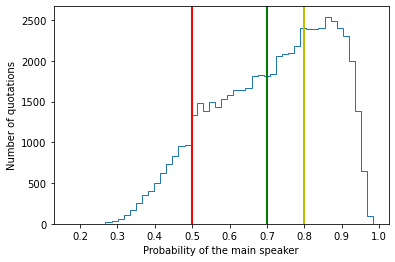

In [39]:
# Distribution of the probability attributed to the main speaker
proba_speaker1 = df_select['probas'].apply(lambda x: x[0][1]).astype(float)
plt.hist(proba_speaker1, bins=50, histtype='step')
plt.axvline(x=0.5, linewidth=2, color='r')
plt.axvline(x=0.7, linewidth=2, color='g')
plt.axvline(x=0.8, linewidth=2, color='y')
plt.xlabel('Probability of the main speaker')
plt.ylabel('Number of quotations')

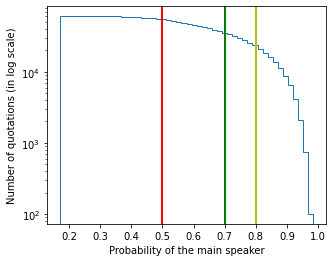

In [40]:
# Same but with log scale for the y-axis and cumulative
plt.figure(figsize=(5,4))
array_cumulative = plt.hist(proba_speaker1, bins=50, log=True, histtype='step', cumulative=-1)
plt.axvline(x=0.5, linewidth=2, color='r')
plt.axvline(x=0.7, linewidth=2, color='g')
plt.axvline(x=0.8, linewidth=2, color='y')
plt.xlabel('Probability of the main speaker')
plt.ylabel('Number of quotations (in log scale)')
plt.show()

In [41]:
# Percentage of quotations removed with the probability p attributed to the main speaker >=0.5 or >=0.7 or >=0.8
print(f"{(len(proba_speaker1[proba_speaker1<0.5]))*100/len(proba_speaker1):.0f}% of quotations would be removed if p>=0.5.")
print(f"{(len(proba_speaker1[proba_speaker1<0.7]))*100/len(proba_speaker1):.0f}% of quotations would be removed if p>=0.7.")
print(f"{(len(proba_speaker1[proba_speaker1<0.8]))*100/len(proba_speaker1):.0f}% of quotations would be removed if p>=0.8.")

# Median probability for the main speaker if if p>=0.5 or p>=0.7 or >=0.8
print(f"p_median = {proba_speaker1[proba_speaker1<0.5].median()} if p>=0.5.")
print(f"p_median = {proba_speaker1[proba_speaker1<0.7].median()} if p>=0.7.")
print(f"p_median = {proba_speaker1[proba_speaker1<0.8].median()} if p>=0.8.")

10% of quotations would be removed if p>=0.5.
43% of quotations would be removed if p>=0.7.
64% of quotations would be removed if p>=0.8.
p_median = 0.4444 if p>=0.5.
p_median = 0.5745 if p>=0.7.
p_median = 0.6396 if p>=0.8.


In [42]:
# Dropping rows where the probability of the main speaker is <0.7
indexNames = df_select[df_select['probas'].apply(lambda x: x[0][1]).astype(float)<0.5].index
df_select.drop(indexNames, inplace=True)
df_select.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,final_quote_SelectWd
3,2020-01-22-008784,"At one point, the Perpetual Guardian four-day ...",Andrew Barnes,[Q57009500],2020-01-22 16:03:41,3,"[[Andrew Barnes, 0.8488], [None, 0.1512]]",[https://www.stuff.co.nz/business/118957804/th...,E,"[point, perpetual, guardian, fourday, week, mo..."
4,2020-01-02-006280,Because basically the logic of everything that...,Ben Rhodes,"[Q4886343, Q4886346, Q4886347, Q4886348]",2020-01-02 00:00:00,1,"[[Ben Rhodes, 0.8202], [None, 0.16], [Nicolle ...",[https://www.rawstory.com/2020/01/nicolle-wall...,E,"[basically, logic, everything, trump, actually..."
5,2020-02-05-010601,"best week [ US President ] Trump has had, poli...",Greg Sheridan,[Q5606248],2020-02-05 08:31:35,1,"[[Greg Sheridan, 0.8975], [None, 0.1025]]",[http://www.skynews.com.au/details/_6129694652...,E,"[best, week, president, trump, politically, si..."
6,2020-02-12-012865,"But on a personal level, I agree with Trump,",Ilham Aliyev,[Q57371],2020-02-12 10:05:14,1,"[[Ilham Aliyev, 0.8786], [None, 0.0915], [Pres...",[https://www.timesofisrael.com/azerbaijan-memo...,E,"[personal, level, agree, trump]"
9,2020-01-02-019876,I enjoy your analysis and instruction on polli...,Steve Bartlett,[Q185480],2020-01-02 00:00:00,1,"[[Steve Bartlett, 0.9232], [None, 0.0754], [Pr...",[http://feeds.foxnews.com/~r/foxnews/politics/...,E,"[enjoy, analysis, instruction, polling, hope, ..."


#### 2.3.3) Dropping quotations which do not have a sufficient number of words   <a class="anchor" id="I.2.3.3"></a>

In [43]:
# Creation of a new dataframe analyze_select to analyze the dataframe df_select
analyze_select = df_select.loc[:, ['quoteID', 'quotation', 'final_quote_SelectWd']].copy(deep=True)

# Adding a column with the number of words per quotation
analyze_select["len_quote"] = df_select["final_quote_SelectWd"].apply(lambda x: len(x))

analyze_select.head()

,quoteID,quotation,final_quote_SelectWd,len_quote
3,2020-01-22-008784,"At one point, the Perpetual Guardian four-day ...","[point, perpetual, guardian, fourday, week, mo...",11
4,2020-01-02-006280,Because basically the logic of everything that...,"[basically, logic, everything, trump, actually...",18
5,2020-02-05-010601,"best week [ US President ] Trump has had, poli...","[best, week, president, trump, politically, si...",7
6,2020-02-12-012865,"But on a personal level, I agree with Trump,","[personal, level, agree, trump]",4
9,2020-01-02-019876,I enjoy your analysis and instruction on polli...,"[enjoy, analysis, instruction, polling, hope, ...",72


Text(0, 0.5, 'Number of quotations')

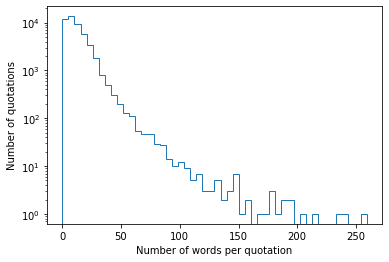

In [44]:
# Distribution of the number of words per quotation
plt.hist(analyze_select["len_quote"], bins=50, histtype='step', log=True)
#plt.axvline(x=0.5, linewidth=2, color='r')
plt.xlabel('Number of words per quotation')
plt.ylabel('Number of quotations')

In [45]:
# Number of quotations with 0 words
print(str(analyze_select[analyze_select["len_quote"]==0].shape[0]) + " quotations with 0 words.")

# Dropping quotations with 0 words
indexNames = analyze_select[analyze_select["len_quote"]==0].index
analyze_select.drop(indexNames, inplace=True)

# Number of quotations with 0 words
print(str(analyze_select[analyze_select["len_quote"]==0].shape[0]) + " quotations with 0 words.")

40 quotations with 0 words.
0 quotations with 0 words.


In [46]:
# Dropping quotations with 0 words
df_select.drop(indexNames, inplace=True)

In [47]:
# Median of the number of words per quotation
analyze_select["len_quote"].median()

10.0

In [48]:
# % of total lines dropped
(df.shape[0] - df_select.shape[0])*100/df.shape[0]

52.92891918208374

### 2.4) Final adjustments  <a class="anchor" id="I.2.4"></a>

In [49]:
# Converting the date column into date format
df_select.date = pd.to_datetime(df_select.date)

df_select is the final dataframe that we will use to answers our questions.

# Part II. Our project about Trump  <a class="anchor" id="PartII"></a>

**_=> QUESTIONS:_**

- **Trump's speech:**
    - 1: What were Donald Trump’s favorite topics to talk about during the campaign (starting in 2015)? and his time in office (20/01/2017 - 20/01/2021)? Is there a change in Trump’s speech/favorite topics between before and after he was elected?
    - 2: How well aligned are Trump’s quotes with its political agenda/program? How close was Donald Trump's presidency from his initial program?
    - 3: Can we note different periods? Can we correlate changes in the ideas expressed by Trump with external events?  


- **External View about Trump:**
    - 4: Can we quantify Trump popularity over time and correlate it with external events? Can we see the impact of his speech on the population (different groups?)?
    - 5: In which newspapers the quotations of Trump are published? Is there a link between the newspapers that published the most quotations of Trump and the political appartenance of these newspapers?
    - 6: What insight can we get from the difference between quotations from a speaker and quotations about a speaker?

## 0) Data and functions  <a class="anchor" id="II.0"></a>

### 0.1) Data  <a class="anchor" id="II.0.1"></a>

In [50]:
# Construction of a dataframe with Trump's quotations
Trump_from = df_select[df_select.speaker.str.lower().str.contains("trump")].copy(deep=True)
display(Trump_from.shape)
display(Trump_from.head())

(24124, 10)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,final_quote_SelectWd
3,2020-01-15-024779,"Here we go again, another con job by the do no...",President Donald Trump,[Q22686],2020-01-15 00:00:00,66,"[[President Donald Trump, 0.7226], [None, 0.13...",[http://feeds.foxnews.com/~r/foxnews/politics/...,E,"[another, nothing, democrat, work, supposed, d..."
4,2020-01-25-013605,How we ever got involved in South Korea in the...,President Donald Trump,[Q22686],2020-01-25 00:00:00,35,"[[President Donald Trump, 0.7131], [None, 0.21...",[http://www.kob.com/news/in-recording-trump-as...,E,"[ever, involved, south, korea, first, place, t..."
5,2020-04-09-018179,I can't believe he's talking about politics wh...,President Trump,[Q22686],2020-04-09 08:45:13,1,"[[President Trump, 0.7307], [None, 0.2433], [T...",[https://www.prisonplanet.com/disgusting-who-c...,E,"[cant, believe, talking, politics, look, relat..."
6,2020-04-08-018085,"I can't tell you in terms of the date,",President Donald Trump,[Q22686],2020-04-08 04:14:10,41,"[[President Donald Trump, 0.8408], [None, 0.11...",[http://feeds.crainsnewyork.com/~r/crainsnewyo...,E,"[cant, tell, term, date]"
9,2020-02-06-038165,I really believe it. And I'm going to work har...,President Donald Trump,[Q22686],2020-02-06 00:00:00,5,"[[President Donald Trump, 0.6817], [None, 0.26...",[http://ktvu.com/news/total-acquittal-trump-de...,E,"[really, believe, going, work, hard]"


In [51]:
# Construction of a daraframe with quotations about Trump
Trump_about= df_select[df_select.final_quote_SelectWd.apply(lambda x : ' '.join(x)).str.contains("trump")].copy(deep=True)
Trump_about.drop(Trump_about[Trump_about.speaker.str.lower().str.contains("trump")].index, inplace=True)
display(Trump_about.shape)
display(Trump_about.head())

(23436, 10)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,final_quote_SelectWd
3,2020-01-22-008784,"At one point, the Perpetual Guardian four-day ...",Andrew Barnes,[Q57009500],2020-01-22 16:03:41,3,"[[Andrew Barnes, 0.8488], [None, 0.1512]]",[https://www.stuff.co.nz/business/118957804/th...,E,"[point, perpetual, guardian, fourday, week, mo..."
4,2020-01-02-006280,Because basically the logic of everything that...,Ben Rhodes,"[Q4886343, Q4886346, Q4886347, Q4886348]",2020-01-02 00:00:00,1,"[[Ben Rhodes, 0.8202], [None, 0.16], [Nicolle ...",[https://www.rawstory.com/2020/01/nicolle-wall...,E,"[basically, logic, everything, trump, actually..."
5,2020-02-05-010601,"best week [ US President ] Trump has had, poli...",Greg Sheridan,[Q5606248],2020-02-05 08:31:35,1,"[[Greg Sheridan, 0.8975], [None, 0.1025]]",[http://www.skynews.com.au/details/_6129694652...,E,"[best, week, president, trump, politically, si..."
6,2020-02-12-012865,"But on a personal level, I agree with Trump,",Ilham Aliyev,[Q57371],2020-02-12 10:05:14,1,"[[Ilham Aliyev, 0.8786], [None, 0.0915], [Pres...",[https://www.timesofisrael.com/azerbaijan-memo...,E,"[personal, level, agree, trump]"
9,2020-01-02-019876,I enjoy your analysis and instruction on polli...,Steve Bartlett,[Q185480],2020-01-02 00:00:00,1,"[[Steve Bartlett, 0.9232], [None, 0.0754], [Pr...",[http://feeds.foxnews.com/~r/foxnews/politics/...,E,"[enjoy, analysis, instruction, polling, hope, ..."


## 0) LDA function  <a class="anchor" id="II.0.2"></a>

To extract topics from Trump's speech, which is needed to answer several of our questions, we will use a topic model. We chose to start with Latent Dirichlet Allocation (LDA), as it is quite straighforward and we have had successful results with it in the past. If our results with LDA are not satisfactory, we will try with [Octis](https://github.com/MIND-Lab/OCTIS), which is used to compare several topic models.

LDA is a generative statistical model which models each document (in our case temporal chunks of quotes by Trump) as a mixture of a number of topics. A topic (in our case, we expect to find subjects such as 'economics', 'ecology', etc.) is itself modeled as a mixture of words. This will thus allow us to extract a certain number of topics from Trump's speech and to see how these topics are represented in each document. Of particular interest to us for configuring our topic extraction are three hyperparameters: alpha (which controls how many topics make up each document), beta (which controls how many words make up each topic) and the number of topics. For more mathematical details, the [wikipedia page for LDA](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) is quite informative.

To check the feasability of LDA in terms of running time and effectiveness, we have implemented a prototype named `timechunk_lda` below. This function aggregates quotations into range of dates of a given size and applies LDA on these aggregated documents. As this was just to test things out, we have not optimized the hyperparameters yet, but we can already see that topics are being extracted quite well.

In [55]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import math
import numpy as np

def make_timechunks(chunksize, min_dt, max_dt):
    '''make timechunks of size chunksize starting at min_dt and ending at max_dt'''
    delta = pd.Timedelta(chunksize)
    num_iters = math.ceil((max_dt-min_dt)/delta)
    a = min_dt
    b = min_dt
    timechunks = []
    for _ in range(num_iters):
        b = a+delta
        timechunks.append([a, b])
        a = b 
    return timechunks

def get_words_and_weights(lda, feature_names, n_top):
    '''get_words_and_weights: retrieve topic words and their weights for each topic'''
    topic_ids = []
    topic_words = []
    words_weights = []
    for topic_id, topic in enumerate(lda.components_):
        top_features_ind = topic.argsort()[: -n_top - 1 : -1]
        top_words = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        topic_ids.append(topic_id)
        topic_words.append(top_words)
        words_weights.append(weights)
    return topic_ids, topic_words, words_weights

def timechunk_lda(df, text_col, dt_col, chunksize, n_components, n_top=10, 
                  max_iter=15, random_state=2, max_df=0.95, min_df=1, 
                  max_features=1000):
    '''timechunk_lda: Aggregate quotes into date ranges of size chunksize and perform
                      latent dirichlet allocation to extract topic
    Inputs:
    -------
    - df: input dataframe
    - text_col: column containing text (either as strings or list of strings) in df
    - dt_col: column containing Timestamps in df
    - chunksize: size of chunks in days, e.g. '10D' == 10 days
    - n_components: number of different topics to model
    - n_top: number of top words to consider when summarizing a topic
    - max_iter: maximum number of iteration for online lda
    - random_state: lda random state
    - max_df: When building the vocabulary ignore terms that have a document frequency 
              strictly higher than the given threshold (corpus-specific stop words). 
              If float, the parameter represents a proportion of documents, integer 
              absolute counts. This parameter is ignored if vocabulary is not None.
    - min_df: When building the vocabulary ignore terms that have a document frequency 
              strictly lower than the given threshold. This value is also called cut-off 
              in the literature. If float, the parameter represents a proportion of 
              documents, integer absolute counts. This parameter is ignored if vocabulary 
              is not None.
    - max_features: vocabulary size
    
    Outputs:
    --------
    - df: input df with two additional columns, `topic_id_{chunksize}` the assigned topic
          and `topics_dist_{chunksize}` the topic assignment distribution.
    - topics_df: topics dataframe, contains topic_id, words and normalized word weight
                 for each topic.
    - timechunks_df: timechunks dataframe, contains start date (included) and end date 
                     (excluded) of each chunk.'''
    # Transform text column to string if passed as list of strings
    created_text_col = False
    if type(df[text_col].to_list()[0]) == list:
        df['str_text_col'] = df[text_col].apply(lambda x: ' '.join(x))
        text_col = 'str_text_col'
        created_text_col = True
    # Create vectorizer and lda objects
    vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, 
                                 max_features=max_features, 
                                 stop_words="english")
    lda = LatentDirichletAllocation(n_components=n_components,
                                    max_iter=max_iter,
                                    learning_method="online",
                                    random_state=random_state)
    # Aggregate documents according to passed chunksize
    documents = []
    documents_lengths = []
    timechunks = make_timechunks(chunksize, df[dt_col].min(), df[dt_col].max())
    for chunk in timechunks:
        document_list = df[
            df[dt_col].between(chunk[0], chunk[1], inclusive='left')
        ][text_col].to_list()
        documents.append(' '.join(document_list))
        documents_lengths.append(len(document_list))
    # Vectorize data
    tokens = vectorizer.fit_transform(documents)
    # Compute topic distribution for each document and assigned topic (argmax)
    assigned_topics = lda.fit_transform(tokens)
    topics_dist_column = []
    topics_column = []
    total_length = 0
    for document_length, assigned_topic in zip(documents_lengths, assigned_topics):
        total_length += document_length
        topics_dist_column.extend(document_length*[list(assigned_topic)])
        topics_column.extend(document_length*[assigned_topic.argmax()])
    # Add to dataframe
    df[f'topic_id_{chunksize}'] = topics_column
    df[f'topics_dist_{chunksize}'] = topics_dist_column
    # Retrieve topic words and associated words
    topic_ids, topic_words, words_weights = get_words_and_weights(
        lda, vectorizer.get_feature_names(), n_top
    )
    # Create topic dataframe with topic_id, chunksize, [word, normalized_weight]
    # normalized weight computed with normalized exponential (softmax) of word weight
    # for each topic
    colnames = ['topic_id', 'chunksize']
    for i in range(1, n_top+1):
        colnames.append(f'topic_word_{i}')
        colnames.append(f'normalized_weight_{i}')
    topics_df = pd.DataFrame(columns=colnames)
    for topic_id, words, weights in zip(topic_ids, topic_words, words_weights):
        tmp = [topic_id, chunksize]
        denom = np.exp(np.array(weights)).sum()
        for word, weight in zip(words, weights):
            normalized_weight = np.exp(weight)/denom
            tmp.extend([word, normalized_weight])
        topics_df.loc[len(topics_df.index)] = tmp
    # Make timechunks_df
    timechunks_df = pd.DataFrame(columns=['start_date', 'end_date'])
    timechunks_df['start_date'] = [chunk[0] for chunk in timechunks]
    timechunks_df['end_date'] = [chunk[1] for chunk in timechunks]
    # Delete additional text column if added
    if created_text_col:
        df.drop(columns=['str_text_col'], inplace=True)
    return df, topics_df, timechunks_df

In [56]:
chunksize = '14D'
df_select_with_topics, topics_df, timechunks_df = timechunk_lda(
    df_select, 'final_quote_SelectWd', 'date', chunksize, 3, 5
)
np.unique(df_select_with_topics[f'topic_id_{chunksize}'].values)

/tmp/ipykernel_9505/1556851603.py:119: RuntimeWarning: overflow encountered in exp
  denom = np.exp(np.array(weights)).sum()
/tmp/ipykernel_9505/1556851603.py:121: RuntimeWarning: overflow encountered in exp
  normalized_weight = np.exp(weight)/denom
/tmp/ipykernel_9505/1556851603.py:121: RuntimeWarning: invalid value encountered in double_scalars
  normalized_weight = np.exp(weight)/denom


array([0, 1, 2])

In [57]:
topics_df

,topic_id,chunksize,topic_word_1,normalized_weight_1,topic_word_2,normalized_weight_2,topic_word_3,normalized_weight_3,topic_word_4,normalized_weight_4,topic_word_5,normalized_weight_5
0,0,14D,coronavirus,1.0,bloomberg,8.811221e-29,modi,3.591722e-46,stone,6.195535e-100,virus,8.112653e-103
1,1,14D,coronavirus,NaN,virus,0.000000e+00,pandemic,0.000000e+00,ventilator,0.000000e+00,covid19,0.000000e+00
2,2,14D,soleimani,1.0,witness,5.212205e-30,peace,2.289984e-34,iraq,7.015156e-35,terrorist,2.150090e-43


In [58]:
timechunks_df

,start_date,end_date
0,2020-01-01,2020-01-15
1,2020-01-15,2020-01-29
2,2020-01-29,2020-02-12
3,2020-02-12,2020-02-26
4,2020-02-26,2020-03-11
5,2020-03-11,2020-03-25
6,2020-03-25,2020-04-08
7,2020-04-08,2020-04-22


## Sentiment analysis

To analyze quotations about Trump, we will use a pre-trained sentiment analysis model, such as [Flair](https://github.com/flairNLP/flair). Such a model would allow us to classify quotations between positive and negative. We chose to start with Flair because it is pre-trained so we believe it will be easier to get started with. It can also take negations and intensifiers into account, and can work for never seen before and misspelt words.

### 1) Question 1  <a class="anchor" id="II.1"></a>

_What were Donald Trump’s favorite topics to talk about during the campaign (starting in 2015)? and his time in office (20/01/2017 - 20/01/2021)? Is there a change in Trump’s speech/favorite topics between before and after he was elected?_

In [52]:
# Creating maks for the campaign and the post-campaign period
mask_campaign = (df['date'] >= '2015-01-01') & (df['date'] < '2017-01-20')
mask_postcampaign = (df['date'] >= '2017-01-20') & (df['date'] <= '2021-01-20')

# Trump_spk[mask_campaign]
# Trump_spk[mask_postcampaign]

## Additional data

### Approval ratings

To be able to better interpret the fluctuations of the sentiments in the quotes about Trump, we chose to use some additional approval rating data. The data comes from https://projects.fivethirtyeight.com/trump-approval-ratings/. We chose this data source for the following reasons: 
- it aggregates the results of several polls, so it should be more representative
- it includes error bars, so we will be able to see if our interpretations are statistically significant

Below we load the data into a dataframe and plot it as a line.

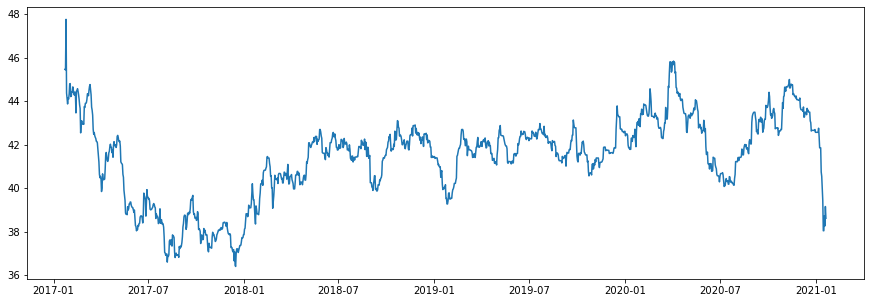

In [89]:
df_approval = pd.read_csv("data/approval_topline.csv")
df_approval = df_approval[df_approval.subgroup == "All polls"][["modeldate", "approve_estimate"]].iloc[::-1].reset_index(drop=True)
df_approval["modeldate"] = pd.to_datetime(df_approval["modeldate"])
from matplotlib.pyplot import figure
figure(figsize=(15, 5))
plt.plot(df_approval["modeldate"], df_approval["approve_estimate"])